# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system utilizes antibodes, and efforts to design antibodies that function more potently.

In [14]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import brentq

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    # Check that there is a solution
    if diffFunAnon(0) * diffFunAnon(Rtot) > 0:
        raise RuntimeError("There is no solution with these parameters. Are your inputs correct?")

    # Vector of binomial coefficients
    Req = brentq(diffFunAnon, 0, Rtot, disp=False)

    # Calculate vieq from equation 1
    vieq = L0*(1/Kd)*Req*(binom(v, np.arange(1, v + 1))) * np.power(Kx*Req, np.arange(v))

    # Calculate L, according to equation 7
    Lbound = np.sum(vieq)

    # Calculate Rmulti from equation 5
    Rmulti = np.sum(np.multiply(vieq[1:], np.arange(2, v + 1, dtype=np.float)))

    # Calculate Rbound
    Rbnd = np.sum(np.multiply(vieq, np.arange(1, v + 1, dtype=np.float)))

    # Calculate numXlinks from equation 4
    nXlink = np.sum(np.multiply(vieq[1:], np.arange(1, v, dtype=np.float)))

    return (Lbound, Rbnd, Rmulti, nXlink)

data = np.loadtxt("./data/wk3-stone.csv", delimiter=",")

# Vector of the ligand concentrations, cell response (proportional to Rmulti), valencies
Xs, Ys, Vs = np.hsplit(data, 3)

Xs = np.squeeze(Xs)
Ys = np.squeeze(Ys)
Vs = np.squeeze(Vs)

#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

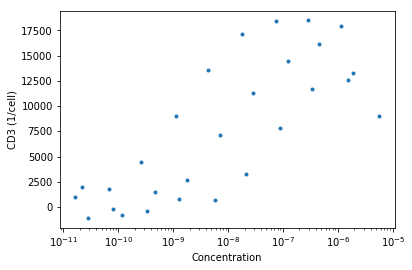

In [15]:
plt.semilogx(Xs, Ys, '.');
plt.xlabel('Concentration');
plt.ylabel('CD3 (1/cell)');

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

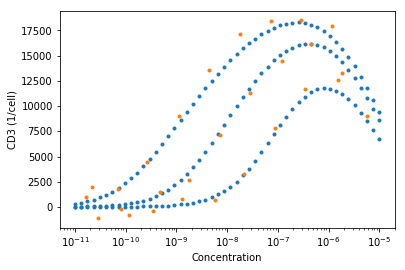

In [17]:
XsSim = np.repeat(np.logspace(-11, -5), 3)
VsSim = np.tile(np.array([2, 3, 4]), 50)

def predict(Rtot, Kd, Kx, Vs, Ls, scale):
    pred = np.zeros(Ls.shape) 
    
    for ii in range(Ls.size):
        pred[ii] = StoneMod(Rtot, Kd, Vs[ii], Kx, Ls[ii])[2]
    
    return pred * scale

Rtot = 24000

ss = predict(Rtot, 1.7E-6, 3.15E-4, VsSim, XsSim, 1.0)

plt.semilogx(XsSim, ss, '.');
plt.semilogx(Xs, Ys, '.');
plt.xlabel('Concentration');
plt.ylabel('CD3 (1/cell)');

#### (2) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [18]:
Ypred = lambda x: predict(Rtot, x[0], x[1], Vs, Xs, x[2]) - Ys

from scipy.optimize import least_squares

sol = least_squares(Ypred, [1.7E-6, 3.15E-4, 1.0])

best_x = sol.x

#### (3) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

In [ ]:
# Answer

#### (4) Using bootstrap estimation, plot the confidence interval of the model along with the data points.

#### (5) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error.

Which paramter influences the fit the most? Which one the least?

In [10]:
ssePred = lambda x: np.sum(np.square(Ypred(x)))

a = np.logspace(-1, 1, num = 41)
b = np.stack((a, a, a))


for ii in range(b.shape[0]):
    for jj in range(b.shape[1]):
        temp = best_x.copy()
        temp[ii] = temp[ii] * a[jj]
        
        b[ii, jj] = ssePred(temp)


b = b / np.min(np.min(b))
        
plt.loglog(a, b[0, :]);
plt.loglog(a, b[1, :]);
plt.loglog(a, b[2, :]);

#### (6) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

In [ ]:
# Answer.

#### (7) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when Kd increases?

Hint: Probably the easiest way to do this is mess with the bounds of the least squares solver.

In [11]:
bglobal = np.stack((a, a, a))

for ii in range(bglobal.shape[0]):
    for jj in range(bglobal.shape[1]):
        temp = best_x.copy()
        temp[ii] = temp[ii] * a[jj]
        
        lb = np.array([-np.inf, -np.inf, -np.inf])
        ub = -lb
        
        lb[ii] = temp[ii] - 1.0E-12
        ub[ii] = temp[ii] + 1.0E-12
        
        bndtemp = (lb, ub)
        
        x0 = [1.7E-6, 3.15E-4, 1.0]
        
        x0[ii] = temp[ii]
        
        bglobal[ii, jj] = least_squares(Ypred, x0, bounds = bndtemp).cost


bglobal = bglobal / np.min(np.min(bglobal))

for ii in range(3):
    plt.loglog(a, bglobal[ii, :]);

#### (8) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters. Are these more or less exactly specified than Rmulti? What can you say about which quantities will be most exactly predicted?

In [ ]:
# Answer

#### (9) Other quantities such as the number of bound receptors may be possible to measure as well. Describe how you would go about fitting this data along with the multimerized receptor measurements. How might more measurements of different types be better than more measurements of the same type?

Answer.